# This is tutorial using TabNetClassifier 
    https://github.com/dreamquark-ai/tabnet (orginal code information)
    This includes Cross Validation test and Hyper parameter tuning
    this code is only for classifcation at the moment (soon I will make tutorial for regressor)


## import libraries

    set target feature and unused function.
    All features need to be float. 

In [17]:
from torch import nn
import torch
from torch import tensor 
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm


train_data= pd.read_csv('./data/1.SuicidalideationPassive_rsfmri_train.csv')
test_data= pd.read_csv('./data/1.SuicidalideationPassive_rsfmri_test.csv')

target ='Suicidalideation.x'
unused_feat = ['Set', 'ideation_attempt.x', 'subjectkey', 'abcd_site', 'Unnamed: 0', 'kflod',
               'src_subject_id','interview_date','gender','eventname']
mri = list(test_data.columns[95:])
Num_FOLDS  = 3
# the number of feature that you want to show 
Num_feat = 20

In [ ]:
n=0
for i in test_data.columns:
    print(i)
    if i =='rsfmri_var_cort.destrieux_g.and.s.frontomargin.lh':
        print(n)
    n +=1

In [18]:
features = mri
print(features)

['rsfmri_var_cort.destrieux_g.and.s.frontomargin.lh', 'rsfmri_var_cort.destrieux_g.and.s.occipital.inf.lh', 'rsfmri_var_cort.destrieux_g.and.s.paracentral.lh', 'rsfmri_var_cort.destrieux_g.and.s.subcentral.lh', 'rsfmri_var_cort.destrieux_g.and.s.transv.frontopol.lh', 'rsfmri_var_cort.destrieux_g.and.s.cingul.ant.lh', 'rsfmri_var_cort.destrieux_g.and.s.cingul.mid.ant.lh', 'rsfmri_var_cort.destrieux_g.and.s.cingul.mid.post.lh', 'rsfmri_var_cort.destrieux_g.cingul.post.dorsal.lh', 'rsfmri_var_cort.destrieux_g.cingul.post.ventral.lh', 'rsfmri_var_cort.destrieux_g.cuneus.lh', 'rsfmri_var_cort.destrieux_g.front.inf.opercular.lh', 'rsfmri_var_cort.destrieux_g.front.inf.orbital.lh', 'rsfmri_var_cort.destrieux_g.front.inf.triangul.lh', 'rsfmri_var_cort.destrieux_g.front.middle.lh', 'rsfmri_var_cort.destrieux_g.front.sup.lh', 'rsfmri_var_cort.destrieux_g.ins.lg.and.s.cent.ins.lh', 'rsfmri_var_cort.destrieux_g.insular.short.lh', 'rsfmri_var_cort.destrieux_g.occipital.middle.lh', 'rsfmri_var_cort.

## Define preproecessing: fillna as 0, set kflod

In [ ]:
def preproecessing (train_data, test_data, NUM_FOLDS):
    test_data_processed= test_data.fillna(0).reset_index(drop=True)
    train_data_processed = train_data.fillna(0).reset_index(drop=True)
    
    test_data_processed["kfold"] = -1

    train_data_processed["kfold"] = -1

    train_data_processed = train_data_processed.sample(frac=1,random_state=2020).reset_index(drop=True)

    kf = KFold(n_splits=NUM_FOLDS)

    for fold, (trn_, val_) in enumerate(kf.split(X=train_data_processed, y=train_data_processed)):
        train_data_processed.loc[val_, 'kfold'] = fold
    print("done preprocessing")
    return train_data_processed, test_data_processed

## Define function of finding best hyperparameters

In [19]:
# Augmented
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm


def find_bestpar(X_train, Y_train, X_valid, Y_valid, X_test, Y_test):
    # Store maximum auc
    max_auc= 0
    # Store maximum hypterparameter set
    max_hy = []
    # define hyperparameter space
    """
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    # Orginal hyperparameter space 
    """
    # define hyperparameter space (quick version)
    n_ = [4]
    lr_ = [2e-2]
    w_ = [0.01]
    g_ = [0.95]
    ss_ = [10, 20]
   
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    
    for hy in tqdm(h_space):
        clf = TabNetClassifier(n_a = hy[0],
                               n_d = hy[0],
                               optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                               scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                               scheduler_fn=torch.optim.lr_scheduler.StepLR,
                               verbose=0
                               )
        clf.fit(X_train, Y_train, X_valid, Y_valid, patience=10, batch_size=256, max_epochs=200)
        #clf.fit(X_train, Y_train, X_valid, Y_valid, patience=50, batch_size=256, max_epochs=200) (Recommended)
        preds_acc = clf.predict(X_test)
        preds_prob = clf.predict_proba(X_test)
        test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
        test_acc = accuracy_score(preds_acc, Y_test)
        print("--------Test auc: {} Test acc:{}-------------".format(test_auc, test_acc) )
        if test_auc>max_auc:
            max_hy = hy
            max_auc = test_auc
    return max_hy

## Do it with best hyperparameter 

In [20]:
def bestpar_tuning(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, max_hy):
 
    hy = max_hy
    clf = TabNetClassifier(n_a = hy[0],
                           n_d = hy[0],
                           optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                           scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           verbose=0
                               )
    clf.fit(X_train, Y_train, X_valid, Y_valid, patience=50, batch_size=256, max_epochs=200)
    preds_acc = clf.predict(X_test)
    preds_prob = clf.predict_proba(X_test)
    test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
    test_acc = accuracy_score(preds_acc, Y_test)
    print("Max hy:" ,hy)
    print("FINAL TEST SCORE(max) test auc: {} test acc: {}".format(test_auc, test_acc))
    return test_auc, clf
    
          

## Find importance feature 

In [21]:
def feature(Num_feat, clf, test_data_processed, features):
    importance =clf.feature_importances_
    plt.plot(importance)
    plt.show()
    labels_importance=importance.argsort()[::-1]

    importance_sort = np.sort(importance)[::-1]

    feat_name_sort=test_data_processed[features].columns[labels_importance]
    important_features = pd.DataFrame() 


    for i in range (Num_feat):
        feature = pd.DataFrame([[feat_name_sort[i],importance_sort[i]]], columns = ['feature name', 'ratio'])
        important_features=pd.concat([important_features,feature])

    return important_features.reset_index(drop=True)

## Define run(find best par, learn with best par, show feature) function 
    set X_test, Y_test, X_train, Y_train, X_valid, Y_valid

In [22]:

def run(train_data_processed, test_data_processed, fold, Num_feat, features):
    X_test = test_data_processed[features].values
    Y_test = test_data_processed[target].values

    df_train = train_data_processed[train_data_processed.kfold != fold]
    df_valid = train_data_processed[train_data_processed.kfold == fold]
    
    X_train = df_train[features].values
    Y_train = df_train[target].values
    
    X_valid = df_valid[features].values
    Y_valid = df_valid[target].values
    
    y_oof = np.zeros((df_valid.shape[0],len(target)))   # Out of folds validation
    
    print("---------------------------------------Training Begining for fold {}-------------------------------".format(fold+1))
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    # Start training
    #max_hy = find_bestpar(X_train, Y_train, X_valid, Y_valid, X_test, Y_test)
    max_hy= h_space[0]
    print("Found maximum hyperparmeter, now work with that")
    
    test_auc, clf = bestpar_tuning(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, max_hy)
    
    import_feat=feature(Num_feat, clf, test_data_processed, features)
    
    return test_auc, import_feat
    
    # VISUALIZTION
    #plt.figure(figsize=(12,6))
    #plt.plot(model.history['train']['loss'])
    #plt.plot(model.history['valid']['loss'])
    
    #Plotting Metric
    #plt.plot([-x for x in model.history['train']['metric']])
    #plt.plot([-x for x in model.history['valid']['metric']])

## Definde function for Cross Validation test 

In [23]:
def hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat):
    CV_auc_all = []
    train_data_processed, test_data_processed = preproecessing (train_data, test_data, Num_FOLDS)
    import_feat_all = pd.DataFrame()
    features = mri
    
    for i in range(Num_FOLDS):
        test_auc, import_feat = run(train_data_processed, test_data_processed, i, Num_feat, features)
        print ("--------Test auc: {} for fold {}-------------".format(test_auc, i+1))
        print ("                                             ")
        print ("---------------------------------------------")
        CV_auc_all.append(test_auc)
        import_feat_all=pd.concat([import_feat_all,import_feat], axis=1)
    print(CV_auc_all)
    print("CV mean Test AUC = ", np.mean(CV_auc_all))
    return import_feat_all

## Finally! you can do hyperparametertuning with Cross validation


done preprocessing
---------------------------------------Training Begining for fold 1-------------------------------
Found maximum hyperparmeter, now work with that
Device used : cuda
Max hy: (4, 0.02, 0.01, 0.95, 10)
FINAL TEST SCORE(max) test auc: 0.48285958097928433 test acc: 0.4796747967479675


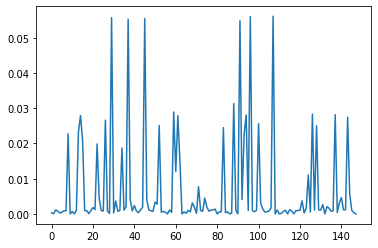

--------Test auc: 0.48285958097928433 for fold 1-------------
                                             
---------------------------------------------
---------------------------------------Training Begining for fold 2-------------------------------
Found maximum hyperparmeter, now work with that
Device used : cuda
Max hy: (4, 0.02, 0.01, 0.95, 10)
FINAL TEST SCORE(max) test auc: 0.4848016713747646 test acc: 0.4796747967479675


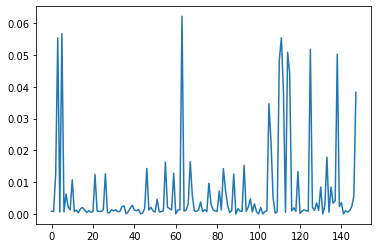

--------Test auc: 0.4848016713747646 for fold 2-------------
                                             
---------------------------------------------
---------------------------------------Training Begining for fold 3-------------------------------
Found maximum hyperparmeter, now work with that
Device used : cuda
Max hy: (4, 0.02, 0.01, 0.95, 10)
FINAL TEST SCORE(max) test auc: 0.5236876177024482 test acc: 0.4796747967479675


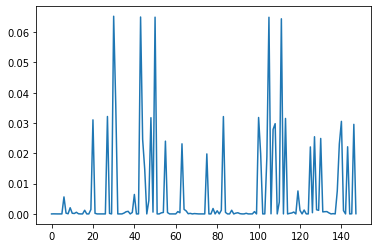

--------Test auc: 0.5236876177024482 for fold 3-------------
                                             
---------------------------------------------
[0.48285958097928433, 0.4848016713747646, 0.5236876177024482]
CV mean Test AUC =  0.49711629001883234


,feature name,ratio,feature name,ratio,feature name,ratio
0,rsfmri_var_cort.destrieux_g.temp.sup.lateral.rh,0.056096,rsfmri_var_cort.destrieux_s.orbital.h.shaped.lh,0.062201,rsfmri_var_cort.destrieux_g.rectus.lh,0.065247
1,rsfmri_var_cort.destrieux_g.oc.temp.med.parahi...,0.055995,rsfmri_var_cort.destrieux_g.and.s.cingul.ant.lh,0.056760,rsfmri_var_cort.destrieux_s.calcarine.lh,0.064997
2,rsfmri_var_cort.destrieux_g.precuneus.lh,0.055698,rsfmri_var_cort.destrieux_g.temporal.middle.rh,0.055450,rsfmri_var_cort.destrieux_s.collat.transv.post.lh,0.064940
3,rsfmri_var_cort.destrieux_s.cingul.marginalis.lh,0.055442,rsfmri_var_cort.destrieux_g.and.s.subcentral.lh,0.055375,rsfmri_var_cort.destrieux_g.subcallosal.rh,0.064909
4,rsfmri_var_cort.destrieux_g.temporal.middle.lh,0.055234,rsfmri_var_cort.destrieux_s.front.inf.rh,0.051768,rsfmri_var_cort.destrieux_g.temporal.middle.rh,0.064408
5,rsfmri_var_cort.destrieux_g.insular.short.rh,0.054818,rsfmri_var_cort.destrieux_lat.fis.post.rh,0.050869,rsfmri_var_cort.destrieux_g.subcallosal.lh,0.036448
6,rsfmri_var_cort.destrieux_g.front.middle.rh,0.031302,rsfmri_var_cort.destrieux_s.parieto.occipital.rh,0.050268,rsfmri_var_cort.destrieux_g.postcentral.lh,0.032157
7,rsfmri_var_cort.destrieux_s.oc.temp.lat.lh,0.028923,rsfmri_var_cort.destrieux_g.temporal.inf.rh,0.048382,rsfmri_var_cort.destrieux_g.cingul.post.ventra...,0.032134
8,rsfmri_var_cort.destrieux_s.front.middle.rh,0.028328,rsfmri_var_cort.destrieux_pole.occipital.rh,0.044300,rsfmri_var_cort.destrieux_g.parietal.sup.rh,0.031826
9,rsfmri_var_cort.destrieux_s.orbital.h.shaped.rh,0.028166,rsfmri_var_cort.destrieux_lat.fis.ant.horizont.rh,0.038491,rsfmri_var_cort.destrieux_s.circular.insula.su...,0.031755


In [24]:
"""
train_data= pd.read_csv('./data/train.ct.csv')
test_data= pd.read_csv('./data/test.ct.csv')
target ='sex'
unused_feat = ['Set', 'subjectkey', 'race.ethnicity', 'abcd_site', 'Unnamed: 0', 'fsqc_qc.y', 'kflod']
Num_FOLDS  = 5
# the number of feature that you want to show 
Num_feat = 5

"""    

hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat)
